# RAG with HoneyHive Tracing

**HoneyHive is an AI monitoring and evaluation platform** that helps developers and businesses build, track, and improve reliable AI applications. It offers tools for performance monitoring, dataset management, debugging, and collaboration, ensuring AI systems run smoothly and scale effectively in production.

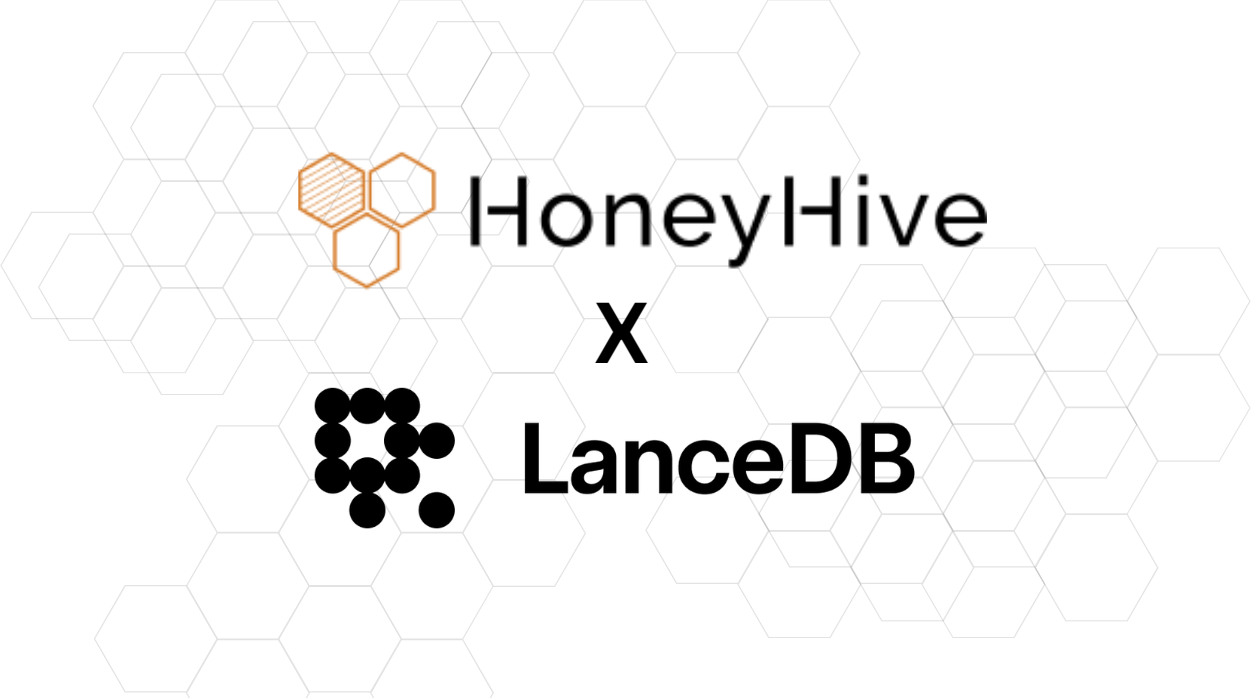

In [ ]:
!pip install lancedb honeyhive sentence-transformers openai pandas

## Step 1: Initialize Clients and Setup
First, set up the necessary clients and configuration for HoneyHive, OpenAI, and LanceDB:

In [ ]:
import os
import sys
import logging
import pandas as pd
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
import openai
from honeyhive import HoneyHiveTracer, trace
from typing import List, Dict, Any

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("rag_pipeline.log"),
        logging.StreamHandler(sys.stdout),
    ],
)
logger = logging.getLogger("lancedb_rag")

# Initialize HoneyHive tracer
HONEYHIVE_API_KEY = os.environ.get("HONEYHIVE_API_KEY", "your honeyhive api key")
HONEYHIVE_PROJECT = os.environ.get("HONEYHIVE_PROJECT", "your honeyhive project name")

HoneyHiveTracer.init(
    api_key=HONEYHIVE_API_KEY,
    project=HONEYHIVE_PROJECT,
    source="dev",
    session_name="lancedb_rag_session",
)

# Set OpenAI API key
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "your openai api key")
openai.api_key = OPENAI_API_KEY

## Step 2: Define Document Class
Create a simple document class to hold text chunks:

In [ ]:
class Document:
    """Simple document class to hold text chunks."""

    def __init__(self, text: str, metadata: Dict[str, Any] = None):
        self.text = text
        self.metadata = metadata or {}

## Step 3: Load and Process Documents with Tracing
Create functions to load and chunk documents with HoneyHive tracing:

In [ ]:
@trace
def load_documents(file_path: str) -> List[Document]:
    """
    Load documents from a text file.
    Each line is treated as a separate document.
    """
    logger.info(f"Loading documents from {file_path}")
    documents = []

    try:
        with open(file_path, "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            if line.strip():  # Skip empty lines
                doc = Document(
                    text=line.strip(), metadata={"source": file_path, "line_number": i}
                )
                documents.append(doc)

        logger.info(f"Loaded {len(documents)} documents")
        return documents
    except Exception as e:
        logger.error(f"Error loading documents: {e}")
        raise


@trace
def chunk_documents(documents: List[Document], chunk_size: int = 1000) -> List[str]:
    """
    Split documents into smaller chunks.
    """
    logger.info(f"Chunking {len(documents)} documents with chunk size {chunk_size}")
    chunks = []

    for doc in documents:
        text = doc.text
        # Simple chunking by character count
        if len(text) <= chunk_size:
            chunks.append(text)
        else:
            # Split into chunks of approximately chunk_size characters
            for i in range(0, len(text), chunk_size):
                chunk = text[i : i + chunk_size]
                chunks.append(chunk)

    logger.info(f"Created {len(chunks)} chunks")
    return chunks

## Step 4: Create LanceDB Table with Tracing
Set up a LanceDB table with embeddings:

In [ ]:
@trace
def create_lancedb_table(chunks: List[str], table_name: str = "docs"):
    """
    Create a LanceDB table with embeddings.
    """
    logger.info(f"Creating LanceDB table '{table_name}' with {len(chunks)} chunks")

    # Connect to LanceDB
    db = lancedb.connect("/tmp/lancedb")

    # Get embedding model
    model = (
        get_registry()
        .get("sentence-transformers")
        .create(name="BAAI/bge-small-en-v1.5", device="cpu")
    )

    # Define schema
    class Docs(LanceModel):
        text: str = model.SourceField()
        vector: Vector(model.ndims()) = model.VectorField()

    # Create table
    df = pd.DataFrame({"text": chunks})

    # Check if table exists and drop if it does
    if table_name in db.table_names():
        db.drop_table(table_name)

    # Create new table
    table = db.create_table(table_name, schema=Docs)

    # Add data
    table.add(data=df)

    logger.info(f"Created table '{table_name}' with {len(chunks)} rows")
    return table

This function creates a LanceDB table and adds document chunks with embeddings. The @trace decorator logs information about the embedding model used and table creation process.

​
## Step 5: Retrieve Documents with Tracing
Create a function to retrieve relevant documents from LanceDB:

In [ ]:
@trace
def retrieve_documents(query: str, table_name: str = "docs", limit: int = 3):
    """
    Retrieve relevant documents from LanceDB.
    """
    logger.info(f"Retrieving documents for query: '{query}'")

    # Connect to LanceDB
    db = lancedb.connect("/tmp/lancedb")

    # Get table
    table = db.open_table(table_name)

    # Search
    results = table.search(query).limit(limit).to_list()

    logger.info(f"Retrieved {len(results)} documents")
    return results

The @trace decorator logs information about the retrieval process, including the query and number of results.

​
## Step 6: Generate Response with Tracing
Create a function to generate a response using OpenAI with tracing:

In [ ]:
@trace
def generate_answer(query: str, context: List[Dict[str, Any]]):
    """
    Generate an answer using OpenAI's API.
    """
    logger.info(f"Generating answer for query: '{query}'")

    # Extract text from context
    context_text = "\n\n".join([item["text"] for item in context])

    # Create prompt
    prompt = f"""
    Answer the following question based on the provided context:

    Context:
    {context_text}

    Question: {query}

    Answer:
    """

    # Call OpenAI API
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that answers questions based on the provided context.",
            },
            {"role": "user", "content": prompt},
        ],
        temperature=0.3,
        max_tokens=500,
    )

    answer = response.choices[0].message.content
    logger.info(f"Generated answer: '{answer[:100]}...'")

    return answer

## Step 7: Complete RAG Pipeline with Tracing
Create a function that combines all the previous steps into a complete RAG pipeline:

In [ ]:
@trace
def rag_pipeline(query: str, data_path: str):
    """
    End-to-end RAG pipeline.
    """
    logger.info(f"Starting RAG pipeline for query: '{query}'")

    # 1. Load documents
    documents = load_documents(data_path)

    # 2. Chunk documents
    chunks = chunk_documents(documents)

    # 3. Create vector store
    table = create_lancedb_table(chunks)

    # 4. Retrieve relevant documents
    results = retrieve_documents(query)

    # 5. Generate answer
    answer = generate_answer(query, results)

    logger.info("RAG pipeline completed successfully")
    return answer

The @trace decorator logs the entire RAG pipeline process, creating a parent span that contains all the child spans from the individual functions.

​
## Step 8: Run the Example
Finally, create a main function to run the example:


Sample dataset has been taken from Llamaindex dataset based off an essay by Paul Graham

In [12]:
!pip install llama-index-cli -q
!llamaindex-cli download-llamadataset PaulGrahamEssayDataset --download-dir ./data

100% 1/1 [00:00<00:00,  2.33it/s]
Successfully downloaded PaulGrahamEssayDataset to ./data


In [ ]:
def main():
    """
    Main function to demonstrate the RAG pipeline.
    """

    # Sample data
    data_path = "/content/data/source_files/source.txt"

    # Sample query
    query = "How did the author's views on artificial intelligence evolve over time, and what were the key moments that led to their disillusionment with early AI approaches?"

    # Run RAG pipeline
    answer = rag_pipeline(query, data_path)

    print("\n=== Final Answer ===")
    print(answer)

    # End HoneyHive tracing session
    HoneyHiveTracer.init(
        api_key=HONEYHIVE_API_KEY,
        project=HONEYHIVE_PROJECT,
        source="dev",
        session_name="new_session",  # This ends the previous session and starts a new one
    )


if __name__ == "__main__":
    main()